# Natural Language Processing

## Project 2: Semantic Relations

In [1]:
import numpy as np
import os
import pandas as pd
import pickle as pk
from pyquery import PyQuery as pq
import re

from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.corenlp import CoreNLPDependencyParser, CoreNLPParser

Using TensorFlow backend.


## 0 Read Data

In [2]:
data_dir = '../data/'
train_file = 'TRAIN_FILE.txt'
test_file = 'TEST_FILE.txt'
test_ans_file = 'answer_key.txt'

In [3]:
cases = ['Cause-Effect(e1,e2)', 'Cause-Effect(e2,e1)', 'Instrument-Agency(e1,e2)', 'Instrument-Agency(e2,e1)', 
         'Product-Producer(e1,e2)', 'Product-Producer(e2,e1)', 'Content-Container(e1,e2)', 'Content-Container(e2,e1)', 
         'Entity-Origin(e1,e2)', 'Entity-Origin(e2,e1)', 'Entity-Destination(e1,e2)', 'Entity-Destination(e2,e1)',
         'Component-Whole(e1,e2)', 'Component-Whole(e2,e1)', 'Member-Collection(e1,e2)', 'Member-Collection(e2,e1)',
         'Message-Topic(e1,e2)', 'Message-Topic(e2,e1)', 'Other']

def parse_sentence(line):
    index, sentence_raw = line.split('\t')
    entities = [pq(sentence_raw)('e%d' % i).text() for i in [1, 2]]
    sentence = re.sub(r'</?e.>|["\n]', '', sentence_raw)
    return index, sentence, entities

def parse_case(line):
    if line[-1] == '\n': line = line[:-1]
    if line in cases:
        return cases.index(line)
    else:
        return -1
        
def read_dataset(data_dir, train_file, test_file, test_ans_file):
    train_data, test_data = [], []
    
    with open(data_dir + train_file, 'r') as f:
        for line in f.readlines():
            if '\t' in line:
                index, sent, ent = parse_sentence(line)
            else:
                case = parse_case(line)
                if case >= 0:
                    train_data += [{'index': int(index), 'sentence': sent, 'entity': ent, 'label': case}]
                    
        train_df = pd.DataFrame(train_data).set_index('index')
        
    with open(data_dir + test_file, 'r') as f:
        for line in f.readlines():
            if '\t' in line:
                index, sent, ent = parse_sentence(line)
                test_data += [{'index': int(index), 'sentence': sent, 'entity': ent, 'label': -1}]
                    
        test_df = pd.DataFrame(test_data).set_index('index')
        
    with open(data_dir + test_ans_file, 'r') as f:
        for line in f.readlines():
            if '\t' in line:
                index, answer = line.split('\t')
                test_df.at[int(index), 'label'] = parse_case(answer)
        
    return train_df, test_df

In [4]:
train_df, test_df = read_dataset(data_dir, train_file, test_file, test_ans_file)

## 1 Dependency Parsing

### 1.1 Different methods

In [6]:
sentence = 'The brown fox is quick and he is jumping over the lazy dog'

** Using `nltk.parse.corenlp.CoreNLPDependencyParser` **

In [7]:
cdp = CoreNLPDependencyParser()
%time cdp.parse(sentence.split())

CPU times: user 20.6 ms, sys: 13.3 ms, total: 33.8 ms
Wall time: 728 ms


** Using `nltk.parse.stanford.StanfordDependencyParser` **

In [8]:
os.environ['CLASSPATH'] = '../stanford-parser-full-2018-02-27'
sdp = StanfordDependencyParser()
%time sdp.parse(sentence.split())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.StanforCoreNLPDependencyParser instead.
  


CPU times: user 8.75 ms, sys: 25.3 ms, total: 34.1 ms
Wall time: 3.31 s


### 1.2 Find the dependency path

** Dependency tree **

In [9]:
def find_dependency_tree(sentence):
    tree, = cdp.parse(sentence.split())
    tree_list = [('', 'ROOT', '0', 'ROOT')] + [tuple(r.split('\t')) for r in tree.to_conll(4).split('\n')][:-1]
    return tree_list, tree

** Dependency path **

In [10]:
def find_entity_index(tree_list, e):
    for i, d in enumerate(tree_list):
        if d[0] == e: return i
    return -1

def find_root_path(tree_list, e):
    path = []
    i = find_entity_index(tree_list, e)
    while True:
        ent, tag, parent, arrow = tree_list[i]
        path += [[ent, tag, arrow]]
        i = int(parent)
        if arrow is 'ROOT': break
    return path

def _merge_path(p1, p2):
    rp1, rp2 = p1[::-1], p2[::-1]
    max_len = min(len(p1), len(p2))
    
    path = []
    for i in range(max_len):
        if rp1[i] == rp2[i]:
            m1 = len(p1) - i - 1
            m2 = i
        else:
            m1 = len(p1) - i
            m2 = i - 1
            break
    
    path = p1[:m1] + rp2[m2:]
    return path, m1

def fix_transition_and_direction(path, mp):
    path[mp][2] = 'end'
    for i in range(mp, len(path)-1): # shift forward the transition tag from merge point
        path[i][2] = path[i+1][2]
        path[i+1][2] = 'end'
        
    for i in range(len(path)): # before merge point: 1, after merge point: 0
        path[i][2] = path[i][2].split(':')[0]
        if i < mp: path[i][2] += '-inv'
            
    return path

def merge_path(p1, p2):
    path, mp = _merge_path(p1, p2)
    
    if len(path) == 0 or mp < 0:
        print("Can't merge two path")
        
    else:
        path = fix_transition_and_direction(path, mp)
                
    return path

def find_dependency_path(tree_list, entities):
    e1, e2 = entities
    p1 = find_root_path(tree_list, e1)
    p2 = find_root_path(tree_list, e2)
    path = merge_path(p1, p2)
    return path

In [11]:
print(sentence)
tree_list, tree = find_dependency_tree(sentence)
path = find_dependency_path(tree_list, ['The', 'dog'])
print(path)

The brown fox is quick and he is jumping over the lazy dog
[['The', 'DT', 'det-inv'], ['fox', 'NN', 'nsubj-inv'], ['quick', 'JJ', 'conj'], ['jumping', 'VBG', 'dobj'], ['dog', 'NN', 'end']]


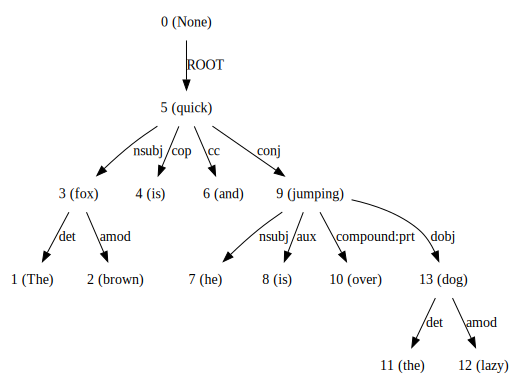

In [17]:
tree

## 2 Preprocess Data: Tokenize

### 2.2 Tokenizers

** Word tokenizer **

In [18]:
def get_word_tokenizer(train_df, test_df):
    word_tokenizer = Tokenizer()
    all_corpus = list(train_df.loc[:]['sentence']) + list(test_df.loc[:]['sentence'])
    word_tokenizer.fit_on_texts(all_corpus)
    return word_tokenizer

In [19]:
word_tokenizer = get_word_tokenizer(train_df, test_df)
word_index = word_tokenizer.word_index

** POS tags & dependency tags **

In [20]:
def init_tags():
    pos_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP',
                'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 
                'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

    dep_half_tags = ['nsubj', 'nsubjpass', 'dobj', 'iobj', 'csubj', 'csubjpass', 'ccomp', 'xcomp',
                     'nmod', 'advcl', 'advmod', 'neg',
                     'vocative', 'discourse', 'expl', 'aux', 'auxpass', 'cop', 'mark', 'punct',
                     'nummod', 'appos', 'acl', 'amod', 'det',
                     'compound', 'name', 'mwe', 'foreign', 'goeswith', 
                     'conj', 'cc',
                     'case', 'list', 'dislocated', 'parataxis', 'remnant', 'reparandum',
                     'root', 'dep']
    dep_tags = []
    for tag in dep_half_tags:
        dep_tags += [tag]
        dep_tags += [tag + '-inv']

    dep_tags = list(np.sort(dep_tags)) + ['end']
    
    return pos_tags, dep_tags

### 2.4 Convert POS tags & dependency tags to sequences

In [23]:
def split_path_content(path, pos_tags, dep_tags):
    path_sent, pos_seq, dep_seq = '', [], []
    
    for node in path:
        word, pt, dt = node
        path_sent += word + ' '
        if pt not in pos_tags: pos_tags += [pt]
        if dt not in dep_tags: dep_tags += [dt]
        pos_seq += [pos_tags.index(pt)]
        dep_seq += [dep_tags.index(dt)]
    
    return path_sent, pos_seq, dep_seq, pos_tags, dep_tags

In [24]:
pos_tags, dep_tags = init_tags()
sent, pos, dep, pos_tags, dep_tags = split_path_content(path, pos_tags, dep_tags)
print(sent, '\n', pos, '\n', dep)

The fox quick jumping dog  
 [2, 11, 6, 28, 11] 
 [33, 61, 22, 38, 80]


### 2.5 Preprocess Main Function

In [23]:
def _preprocess_data(df, word_tokenizer, pos_tags, dep_tags, max_seq_len):
    data, path_sent, pos_seq, dep_seq, labels = {}, [], [], [], []
    
    if debug:
        f = open('log.txt', 'wa')
    
    for i, row in df.iterrows():
        tree_list, tree = find_dependency_tree(row['sentence'])
        path = find_dependency_path(tree_list, row['entity'])
        print('\r[%d]' % i, end='')
        if debug:
            print('[%d]' % i, file=f)
            print(row['sentence'], row['entity'], file=f)
            print(tree_list, file=f)
            print(path, '\n', file=f)
        psent, pos, dep, pos_tags, dep_tags = split_path_content(path, pos_tags, dep_tags)
        
        path_sent += [psent]
        pos_seq += [pos]
        dep_seq += [dep]
        labels += [row['label']]
    
    if debug:
        f.close()
            
    path_seq = word_tokenizer.texts_to_sequences(path_sent)
    data['path_seq'] = pad_sequences(path_seq, maxlen=max_seq_len)
    data['pos_seq'] = pad_sequences(pos_seq, maxlen=max_seq_len)
    data['dep_seq'] = pad_sequences(dep_seq, maxlen=max_seq_len)
    data['labels'] = to_categorical(labels)
    
    return data, pos_tags, dep_tags

def preprocess_data(train_df, test_df, max_seq_len=8):
    word_tokenizer = get_word_tokenizer(train_df, test_df)
    
    pos_tags, dep_tags = init_tags()
    
    train_data, pos_tags, dep_tags = \
        _preprocess_data(train_df, word_tokenizer, pos_tags, dep_tags, max_seq_len)
    test_data, pos_tags, dep_tags = \
        _preprocess_data(test_df, word_tokenizer, pos_tags, dep_tags, max_seq_len)
    
    return train_data, test_data, pos_tags, dep_tags, word_tokenizer

In [24]:
debug = False
%time train_data, test_data, pos_tags, dep_tags, word_tokenizer = preprocess_data(train_df, test_df)

[10717]CPU times: user 46.9 s, sys: 5.66 s, total: 52.5 s
Wall time: 4min 23s


## 3 Embedding Layers

### 3.1 Read GloVe

In [30]:
def read_glove(data_dir, glove_file):
    word_vectors = []
    with open(data_dir + glove_file, 'r', encoding='UTF-8') as f:
        for line in f:
            word, *vector = line.split()
            word_vectors += [{'word': word, 'vector': list(map(float, vector))}]

    return pd.DataFrame(word_vectors).set_index('word')

In [31]:
glove_file = "glove.6B/glove.6B.300d.txt"
%time word_vectors = read_glove(data_dir, glove_file)

CPU times: user 55.8 s, sys: 19.7 s, total: 1min 15s
Wall time: 1min 29s


### 3.2 Construct Embedding Layers

In [43]:
def get_word_embedding_layer(word_index, word_vectors, max_sequence_len=8):
    embedding_dim = 300
    word_len = len(word_index) + 1
    word_embedding_matrix = np.zeros((word_len, embedding_dim))
    for word, i in word_index.items():
        word_vector = word_vectors.get(word)
        if word_vector is not None:
            word_embedding_matrix[i] = word_vector
    
    word_embedding_layer = Embedding(word_len, embedding_dim, weights=[word_embedding_matrix],
                                     input_length=max_sequence_len, trainable=False)
    
    return word_embedding_layer

In [44]:
def get_tag_embedding_layer(tag_len, max_sequence_len=8):
    tag_embedding_list = []
    for i in range(tag_len):
        vector = [0] * tag_len
        vector[i] = 1
        tag_embedding_list += [vector]
        
    tag_embedding_matrix = np.array(tag_embedding_list)
    tag_embedding_layer = Embedding(tag_len, tag_len, weights=[tag_embedding_matrix],
                                    input_length=max_sequence_len, trainable=False)
    
    return tag_embedding_layer

## 4 Construct Model

In [57]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.layers.merge import Concatenate
from keras.models import Model

In [46]:
def construct_model(max_sequence_len, word_dim, pos_dim, dep_dim, categories,
                    word_index, word_vectors):
    
    in_word = Input(shape=(max_sequence_len,), name='Input-Word')
    in_pos = Input(shape=(max_sequence_len,), name='Input-POS')
    in_dep = Input(shape=(max_sequence_len,), name='Input-Dependency')
    
    emb_word = get_word_embedding_layer(word_index, word_vectors, max_sequence_len)(in_word)
    emb_pos = get_tag_embedding_layer(pos_dim, max_sequence_len)(in_pos)
    emb_dep = get_tag_embedding_layer(dep_dim, max_sequence_len)(in_dep)
    
    lstm_word = LSTM(128, activation='relu', dropout=0.2, name='LSTM-Word')(emb_word)
    lstm_pos = LSTM(32, activation='relu', dropout=0.2, name='LSTM-POS')(emb_pos)
    lstm_dep = LSTM(32, activation='relu', dropout=0.2, name='LSTM-Dependency')(emb_dep)
    
    x = Concatenate(name='Concatenate')([lstm_word, lstm_pos, lstm_dep])
    x = Dense(64, activation='relu', name='Dense')(x)
    x = Dropout(0.2, name='Dropout')(x)
    out = Dense(categories, activation='softmax', name='Output')(x)
    
    model = Model(inputs=[in_word, in_pos, in_dep], outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    
    return model

In [65]:
max_sequence_len = 8
word_dim = 300
pos_dim = len(pos_tags)
dep_dim = len(dep_tags)
categories = 19
word_index = word_tokenizer.word_index

In [66]:
model = construct_model(max_sequence_len, word_dim, pos_dim, dep_dim, categories, word_index, word_vectors)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input-Word (InputLayer)          (None, 8)             0                                            
____________________________________________________________________________________________________
Input-POS (InputLayer)           (None, 8)             0                                            
____________________________________________________________________________________________________
Input-Dependency (InputLayer)    (None, 8)             0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 8, 300)        6891000     Input-Word[0][0]                 
___________________________________________________________________________________________

In [67]:
def train_model(model, model_path, train_data, test_data):
    
    train_X = [train_data[k] for k in ['path_seq', 'pos_seq', 'dep_seq']]
    train_Y = train_data['labels']
    
    test_X = [test_data[k] for k in ['path_seq', 'pos_seq', 'dep_seq']]
    test_Y = test_data['labels']
    
    es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
    cp = ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=False,
                         mode='min', filepath=model_path)
    
    history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y),
                         epochs=30, verbose=1, batch_size=32, callbacks=[es, cp])

    hist = history.history
    return model, hist

In [68]:
model, hist = train_model(model, '../model/lstm.h5', train_data, test_data)

Train on 8000 samples, validate on 2717 samples
Epoch 1/30
8000/8000 [==============================] - 52s - loss: 0.2555 - val_loss: 0.1923
Epoch 2/30
8000/8000 [==============================] - 26s - loss: 0.1925 - val_loss: 0.1849
Epoch 3/30
8000/8000 [==============================] - 26s - loss: 0.1827 - val_loss: 0.1726
Epoch 4/30
8000/8000 [==============================] - 25s - loss: 0.1752 - val_loss: 0.1696
Epoch 5/30
8000/8000 [==============================] - 25s - loss: 0.1708 - val_loss: 0.1634
Epoch 6/30
8000/8000 [==============================] - 26s - loss: 0.1678 - val_loss: 0.1607
Epoch 7/30
8000/8000 [==============================] - 25s - loss: 0.1659 - val_loss: 0.1601
Epoch 8/30
8000/8000 [==============================] - 25s - loss: 0.1632 - val_loss: 0.1568
Epoch 9/30
8000/8000 [==============================] - 25s - loss: 0.1624 - val_loss: 0.1577
Epoch 10/30
8000/8000 [==============================] - 26s - loss: 0.1606 - val_loss: 0.1555
Epoch 11/30